In [1]:
import xarray as xr 
import numpy as np
import gsw as gsw
import OCAPE_functions_xarray as Of_xr #A is the residu of 'Annual'
from scipy.optimize import linear_sum_assignment
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature



In [2]:
long_min=-180
long_max=360
lat_min=60
lat_max=90
M=250

ds_sal = xr.open_dataset("/path/to/file/anual_sal.nc")
ds_temp = xr.open_dataset("/path/to/file/anual_temp.nc")


In [3]:
press_bis_AX = -ds_temp.Z
longitude_AX = ds_temp.X
latitude_AX = ds_temp.Y

press = xr.apply_ufunc(gsw.conversions.p_from_z, press_bis_AX, latitude_AX)
abs_sal_3dz = xr.apply_ufunc(gsw.conversions.SR_from_SP, ds_sal)
Ctemp_3dz = xr.apply_ufunc(gsw.conversions.CT_from_t, abs_sal_3dz.sal, ds_temp, press)

/home/x_titmo/work/veros_env_new/lib/python3.10/site-packages/gsw/_utilities.py:72: RuntimeWarning: invalid value encountered in cast
  newargs.append(np.asarray(arg, dtype=float))


In [4]:
#Slice the original data to conserved only the considered latitudes and longitudes
lat_AX=latitude_AX.sel(Y=slice(lat_min, lat_max))
long_AX=longitude_AX.sel(X=slice(long_min, long_max))

N_CT_3d = Ctemp_3dz.sel(Y=slice(lat_min, lat_max), X=slice(long_min, long_max))
Nabs_sal_3dz = abs_sal_3dz.sel(Y=slice(lat_min, lat_max), X=slice(long_min, long_max))


press_to_interpol = press.sel(Y=lat_max, method='nearest')


In [5]:
press_AX = xr.DataArray(np.linspace(0, press.sel(Y=slice(lat_min, lat_max)).max(), M), dims=["press"])
P = press_AX.expand_dims({'X':len(Nabs_sal_3dz.X),'Y':len(Nabs_sal_3dz.Y)  })

In [6]:
ds = Nabs_sal_3dz
# Define the new press_bis axis (50 points)
press_bis = press_AX.values
press_bis_broadcasted = xr.DataArray(
    np.broadcast_to(press_bis, (len(ds['X']), len(ds['Y']), len(press_bis))),
    dims=['X', 'Y', 'press_bis'],
    coords={'X': ds['X'], 'Y': ds['Y'], 'press_bis': press_bis}
)

In [7]:
CTofP=Of_xr.interpolate_xarray(N_CT_3d, press_bis_broadcasted)
ASofP=Of_xr.interpolate_xarray(Nabs_sal_3dz, press_bis_broadcasted)

In [8]:
# Reshape using expand_dims to prepare for broadcasting
aS1_expanded = ASofP.sal.expand_dims({'press_bis_2': M}, axis=1)  # Shape becomes (M, 1)
cT_expanded = CTofP.temp.expand_dims({'press_bis_2': M}, axis=1)  # Shape becomes (M, 1)
P_expanded = press_bis_broadcasted.expand_dims({'press_bis_2': M}).rename({'press_bis': 'press_bis_2', 'press_bis_2': 'press_bis'}) # Shape becomes (1, M)
# Compute the enthalpy matrix using broadcasting
enthalpy_matrix = gsw.energy.enthalpy(aS1_expanded,cT_expanded, P_expanded)
enthalpy_matrix =enthalpy_matrix.T
enthalpy_from_vec=gsw.energy.enthalpy(ASofP.sal, CTofP.temp, press_bis_broadcasted)

# Apply the function across all (lat, lon) combinations
result = xr.apply_ufunc(
    Of_xr.compute_rpe_single_ignore_nan,
    enthalpy_matrix,
    input_core_dims=[["press_bis", "press_bis_2"]],
    output_core_dims=[[],["rows_result"], ["cols_result"]],
    vectorize=True,
    dask="allowed",  # Enables compatibility with lazy computation
    output_dtypes=[float,int,int],
)

rpe_all=result[0]
iPE=enthalpy_from_vec.mean(dim='press_bis')
reduced_APE = iPE-rpe_all

In [9]:
def plot_polar_contourboth(values1, azimuths, radii, hemisphere, label_values1='Not specified',size_of_fig=(6.4, 4.8)):     
    radii=90-radii
    
    theta = np.radians(azimuths)
    radii = np.array(radii)
    theta, r = np.meshgrid(np.radians(azimuths), radii)
    
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),figsize=size_of_fig)
    
    if hemisphere=='N':
        ax.set_theta_zero_location("S")
        ax.set_theta_direction(1)
    elif hemisphere=='S':
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
    
    cax1 = ax.contourf(theta, r, values1,levels = 50, cmap='cmo.dense')
    cb = fig.colorbar(cax1,label=label_values1)

 
    return fig, ax, cax1

(<Figure size 640x480 with 2 Axes>,
 <PolarAxes: >,
 <matplotlib.contour.QuadContourSet at 0x7f3178d7d6c0>)

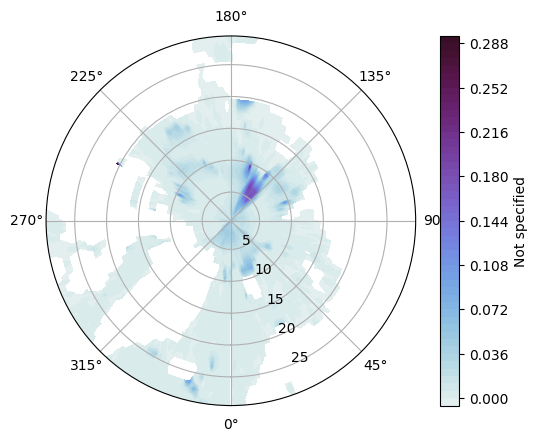

In [10]:
plot_polar_contourboth(reduced_APE, reduced_APE.X, reduced_APE.Y, 'N')